In [ ]:
#TODO: Handle leverage by security
#TODO: Then handle Defensive vs aggressive exposition
#TODO: Replace with true regime model and securities
#TODO: Backtest find the best

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from utility.types import RebalanceFrequencyEnum, AllocationMethodsEnum
from data.universe import Universe
from data.benchmark import Benchmark

from backtest.backtest import Backtester

In [34]:
universe = Universe.get_universe_returns()
universe

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX
date,,,,,
2016-06-01,0.000000,0.000000,0.000000,0.000000,0.000000
2016-06-02,-0.000010,0.004860,0.004419,0.000442,0.003586
2016-06-03,0.000000,-0.010231,-0.005313,-0.009287,-0.017370
2016-06-06,-0.000020,-0.001316,0.014437,0.003236,0.005692
2016-06-07,0.000000,0.006586,0.005512,0.011012,0.005440
...,...,...,...,...,...
2024-02-22,0.000109,0.010694,0.004420,0.012323,0.020330
2024-02-23,0.000119,0.004429,0.000000,0.006920,0.004213
2024-02-26,0.000307,-0.003491,-0.004490,-0.004200,-0.004097


In [38]:
bk_tester = Backtester(universe_returns=universe)


ptf_returns_max_sharpe, ptf_weights_max_sharpe = bk_tester.run_backtest(
    allocation_type=AllocationMethodsEnum.MAX_SHARPE,
    rebalance_frequency=RebalanceFrequencyEnum.QUARTER_START,
    transaction_cost_by_securities = {k:0.001 for k in universe.columns},
    bullish_leverage_by_securities = {k:1.05 for k in universe.columns},
    bearish_leverage_by_securities = {k:1 for k in universe.columns},
    verbose=False,
)
ptf_returns_max_sharpe.name = "ptf_returns_max_sharpe"
ptf_returns_equal_weight, ptf_weights_equal_weight = bk_tester.run_backtest(
    allocation_type=AllocationMethodsEnum.EQUALLY_WEIGHTED,
    rebalance_frequency=RebalanceFrequencyEnum.QUARTER_START,
    transaction_cost_by_securities = {k:0.001 for k in universe.columns},
    verbose=False,
)
ptf_returns_equal_weight.name = "ptf_returns_equal_weight"
ptf_returns_max_sharpe, ptf_returns_equal_weight

(date
 2016-06-29    0.015688
 2016-06-30    0.009447
 2016-07-01    0.005933
 2016-07-04    0.000000
 2016-07-05   -0.002717
                 ...   
 2024-02-22    0.000870
 2024-02-23    0.000276
 2024-02-26    0.000135
 2024-02-27   -0.000018
 2024-02-28    0.000190
 Name: ptf_returns_max_sharpe, Length: 2001, dtype: float64,
 date
 2016-06-29    0.007530
 2016-06-30    0.008343
 2016-07-01   -0.005471
 2016-07-04    0.000000
 2016-07-05   -0.014910
                 ...   
 2024-02-22    0.009742
 2024-02-23    0.003200
 2024-02-26   -0.003220
 2024-02-27    0.000115
 2024-02-28   -0.001246
 Name: ptf_returns_equal_weight, Length: 2001, dtype: float64)

In [39]:
bench = Benchmark(RebalanceFrequencyEnum.MONTH_END)


ptf_and_bench = pd.merge(
    ptf_returns_equal_weight, pd.merge(
    bench.benchmark_returns, ptf_returns_max_sharpe, left_index=True, right_index=True
), left_index=True, right_index=True
)

ptf_and_bench_perf = (ptf_and_bench + 1).cumprod()
ptf_and_bench_perf

,ptf_returns_equal_weight,benchmark_returns,ptf_returns_max_sharpe
2019-10-01,0.978785,0.999993,0.990545
2019-10-02,0.958257,0.981493,0.962752
2019-10-03,0.959404,0.983629,0.961405
2019-10-04,0.967775,0.990607,0.978398
2019-10-07,0.969253,0.993187,0.983004
...,...,...,...
2024-02-09,1.200824,1.323521,1.638253
2024-02-12,1.209619,1.329863,1.639313
2024-02-13,1.198605,1.318233,1.638825
2024-02-14,1.204918,1.323629,1.639015


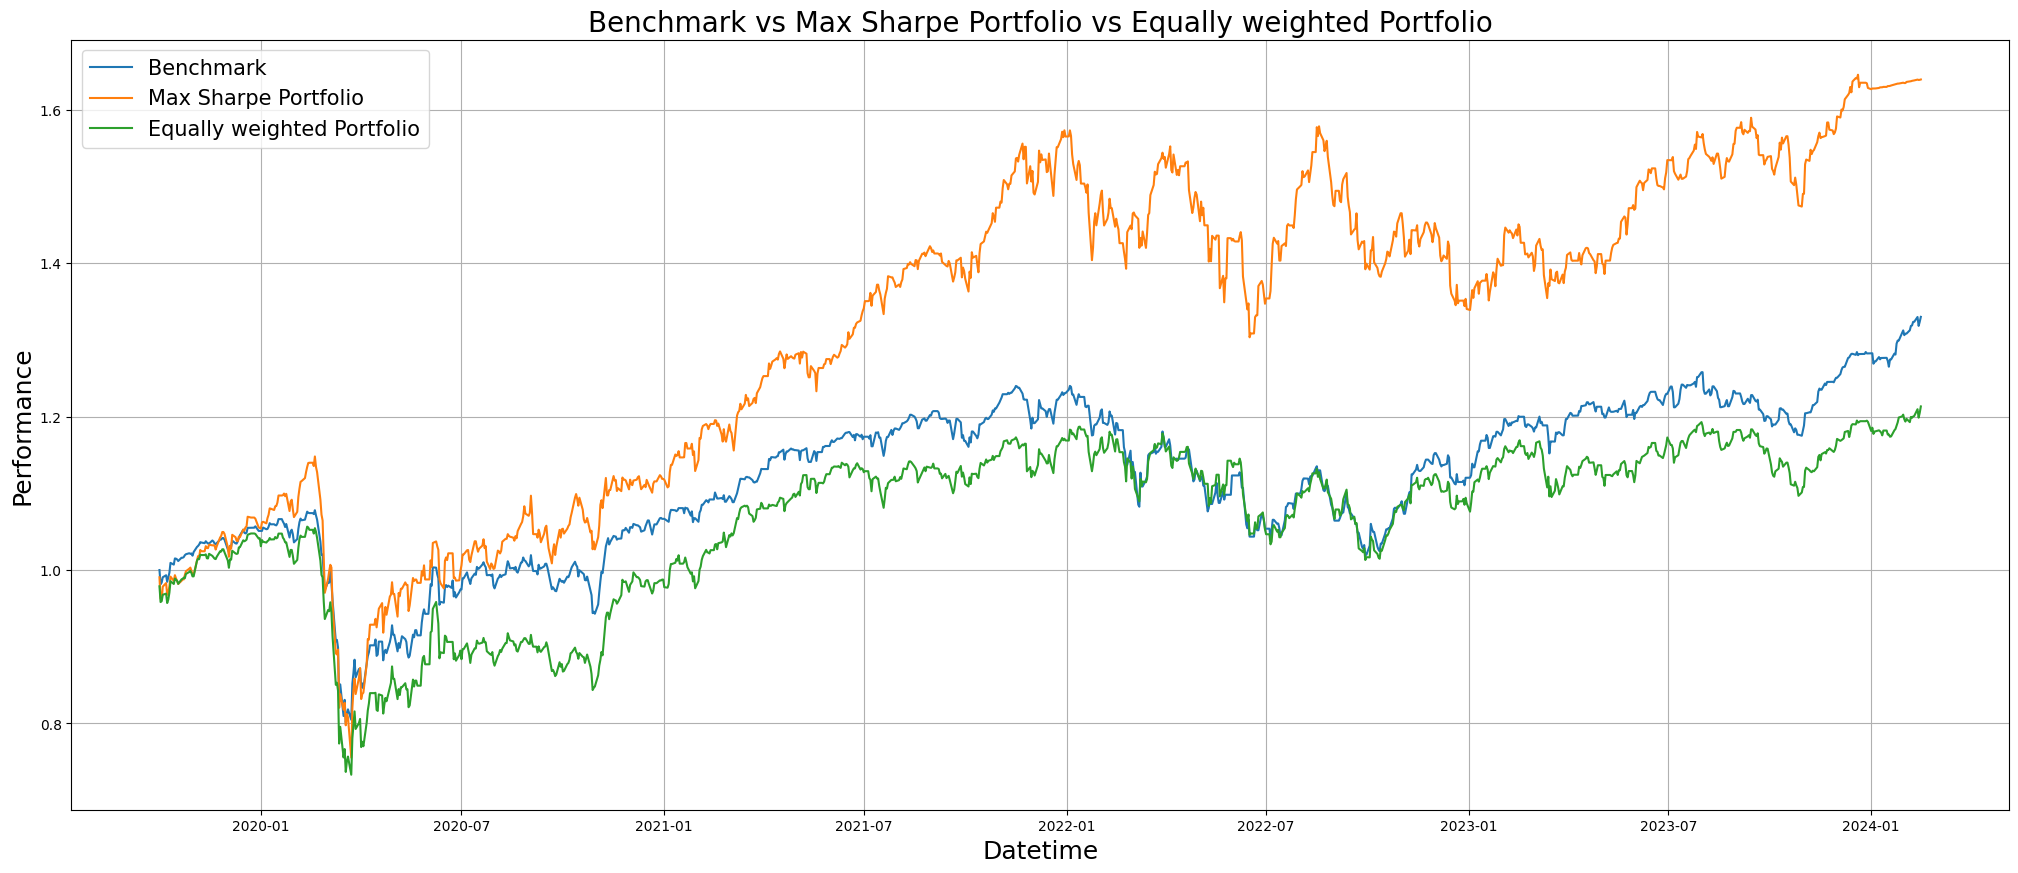

In [40]:
plt.figure(figsize=(25, 10))
plt.plot(ptf_and_bench_perf["benchmark_returns"], label="Benchmark")
plt.plot(ptf_and_bench_perf["ptf_returns_max_sharpe"], label="Max Sharpe Portfolio")
plt.plot(ptf_and_bench_perf["ptf_returns_equal_weight"], label="Equally weighted Portfolio")
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Performance", fontsize=18)
plt.title(
    "Benchmark vs Max Sharpe Portfolio vs Equally weighted Portfolio",
    fontsize=20,
)
plt.grid()
plt.legend(fontsize=15)

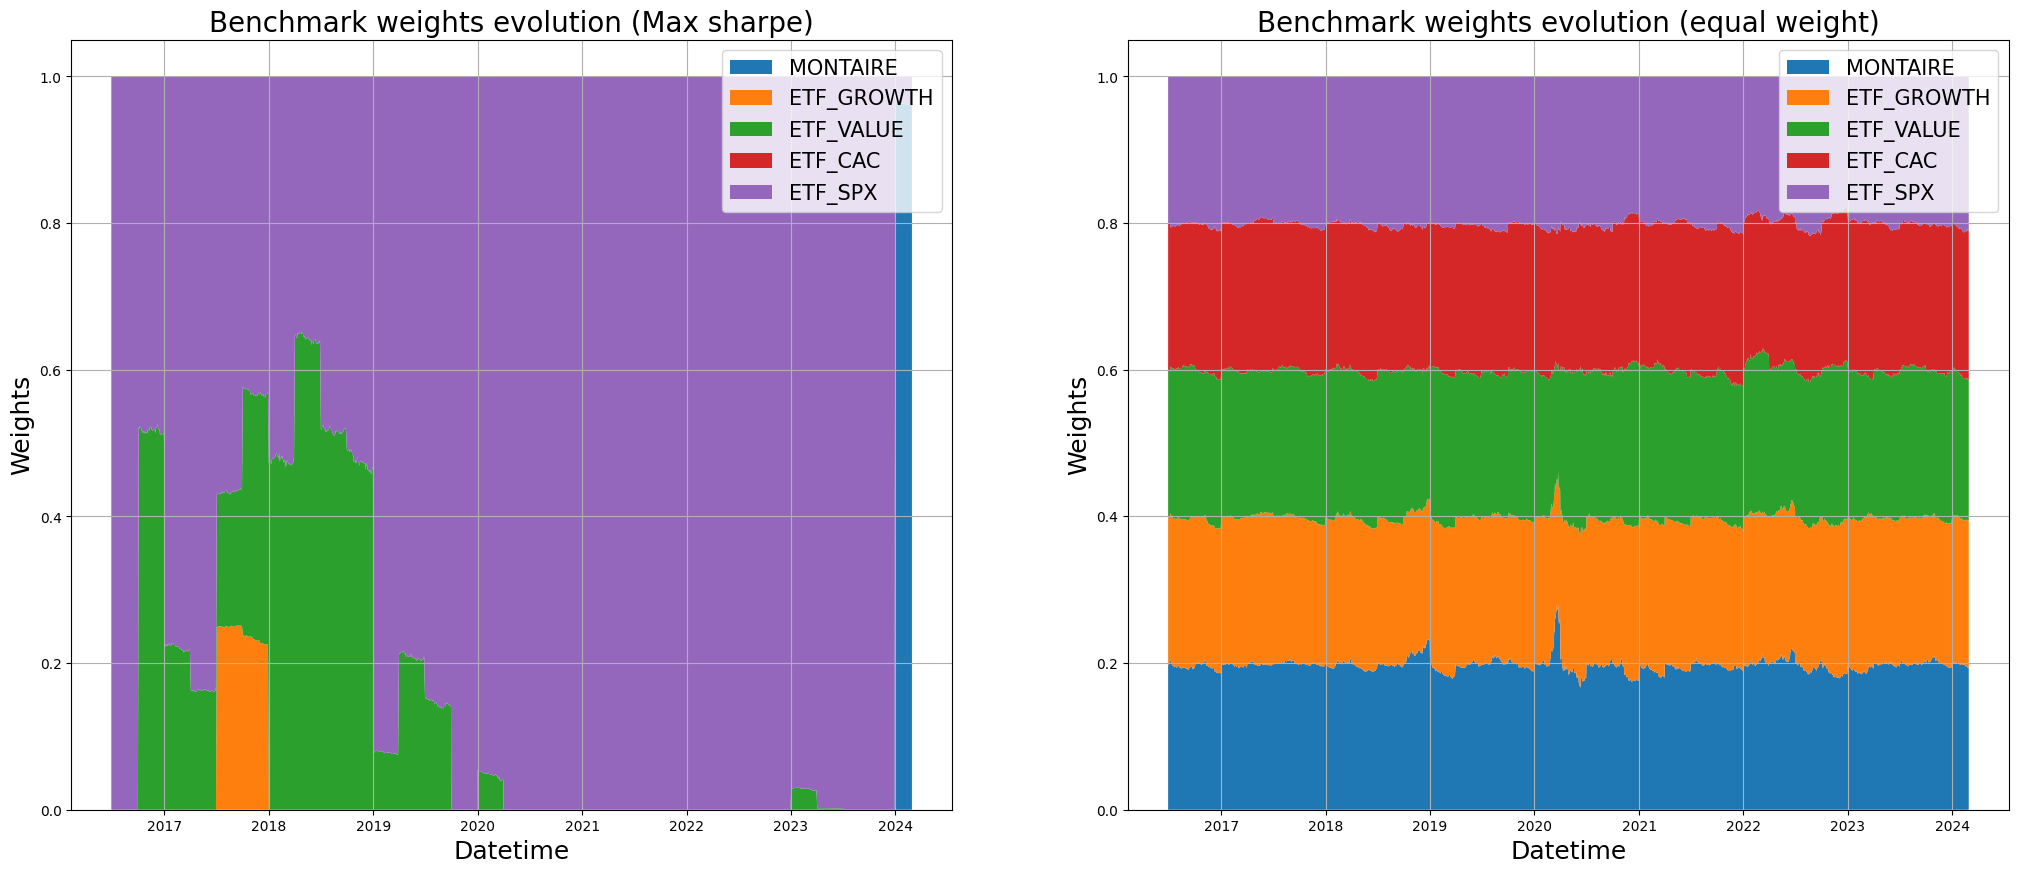

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].stackplot(
    ptf_weights_max_sharpe.index,
    ptf_weights_max_sharpe.to_numpy().T,
)
ax[0].set_xlabel("Datetime", fontsize=18)
ax[0].set_ylabel("Weights", fontsize=18)
ax[0].set_title("Benchmark weights evolution (Max sharpe)", fontsize=20)
ax[0].grid()
ax[0].legend(ptf_weights_max_sharpe.columns.to_list(), fontsize=15)



ax[1].stackplot(
    ptf_weights_equal_weight.index,
    ptf_weights_equal_weight.to_numpy().T,
)
ax[1].set_xlabel("Datetime", fontsize=18)
ax[1].set_ylabel("Weights", fontsize=18)
ax[1].set_title("Benchmark weights evolution (equal weight)", fontsize=20)
ax[1].grid()
ax[1].legend(ptf_weights_equal_weight.columns.to_list(), fontsize=15)
